<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch5_EulersMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Euler's Method (aka "Forward Euler")

In [3]:
import numpy as np
from numpy import sin, cos, exp
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate # use for scipy.interpolate.CubicHermiteSpline
from scipy.integrate import solve_ivp
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'cm'

### Let's solve an IVP
$$y' = -k (y-\cos(t))$$
for $k=5$ and $0 \le t \le 20$ with $y(0)=0.2$.

There's a known true solution
$$y(t)=\frac{y_0 - k^2}{k^2+1}e^{-kt} + k\frac{\sin(t) + k\cos(t)}{k^2+1}$$

t shape: (65,)
y shape: (1, 65)


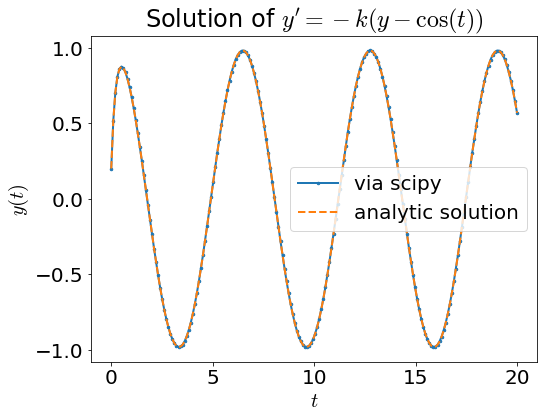

In [4]:
k  = 5 # a parameter
f  = lambda t,y: -k*( y - cos(t) )
y0 = .2;

# We have a known true solution
#   see https://github.com/cu-numcomp/numcomp-class/blob/master/DifferentialEquations.ipynb
y_true = lambda t : (y0 - k**2/(k**2+1) )*exp(-k*t) + k*(sin(t) + k*cos(t))/(k**2+1)


tspan = [0.0,20.0];

sol = solve_ivp(f,tspan,[y0],dense_output=True)
print("t shape:",sol.t.shape)
print("y shape:",sol.y.shape)

y_interpolated = sol.sol # a function!
t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points)[0],".-",MarkerSize=5,label='via scipy')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

#### Now, define our forward Euler

We can easily output an interpolant using Scipy

In [5]:
# write it as "forward_Euler" instead of camelCase "forwardEuler"
#   following suggestions of PEP8 style guide, https://pep8.org/
def forward_Euler( f, y0, tspan, h=0.1, dense_output=False):
  """ Solve IVP y' = f(t,y) on a <= t <= b, y(a)=y0, via improved Euler with stepsize h
  This code has NOT been tested to work with systems.
  Returns tHist, wHist where wHist[i] approximates y( tHist[i] )
  """
  if len(tspan) is not 2:
    raise ValueError("tspan must be array of length 2")
  a, b = tspan[0], tspan[1]  
  # Initialize
  t    = a
  w    = y0
  # Update history
  tHist = [t]
  wHist = [w]  # w[i] approximates y( t[i] )
  dydtHist = []
  # Loop
  while t < b :
    tNext = min(t+h,b)  # don't go too far
    hh    = tNext - t   # hh is just h except perhaps at the last time step
    dydt  = f(t,w)
    w    += hh*dydt     # this is the heart of forward Euler
    t     = tNext
    # Update history
    tHist.append(t)
    wHist.append(w)
    dydtHist.append(dydt)

  dydtHist.append( f(t,w) )# lagged

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(tHist,wHist,dydtHist)
    return np.array(tHist), np.array(wHist), sol
  else:  
    return np.array(tHist), np.array(wHist)

Let's see how we did.  We'll use a stepsize of $h=0.2$

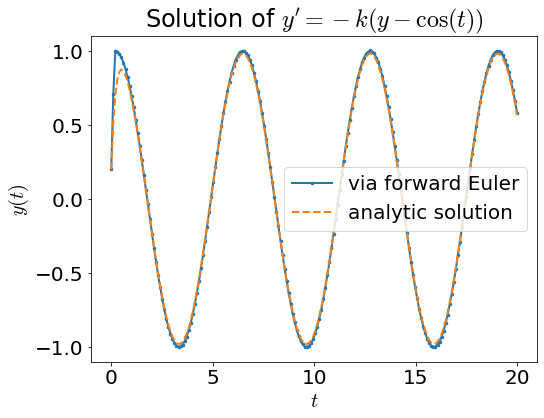

In [8]:
tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=.2,dense_output=True)
len(tHist), len(wHist)

t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points),".-",MarkerSize=5,label='via forward Euler')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

What happens if we use a slightly larger stepsize, $h=0.4$?

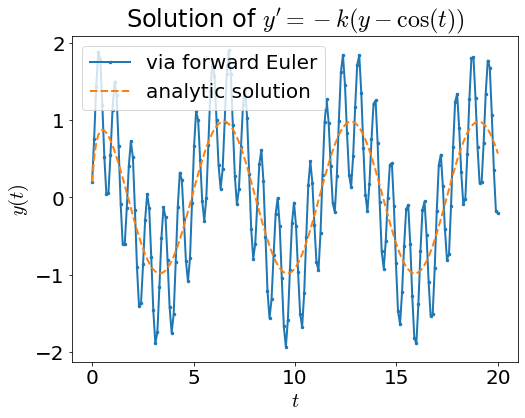

In [9]:
tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=.4,dense_output=True)
len(tHist), len(wHist)

t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points),".-",MarkerSize=5,label='via forward Euler')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

and just a slightly larger stepsize $h=0.5$.  This looks unstable!!

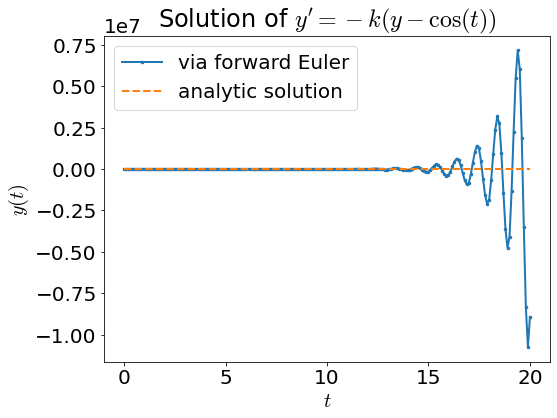

In [10]:
tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=.5,dense_output=True)
len(tHist), len(wHist)

t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points),".-",MarkerSize=5,label='via forward Euler')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

#### Now let's look at error systematically

We expect error to decay as $h\to 0$, and in fact, at $O(h)$

In [11]:
hList = np.logspace(-1,-5,20)
eList = [] # error list
for h in hList:
  tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=h,dense_output=True)
  t  = np.linspace(tspan[0],tspan[1],1000)
  err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
  eList.append( err )


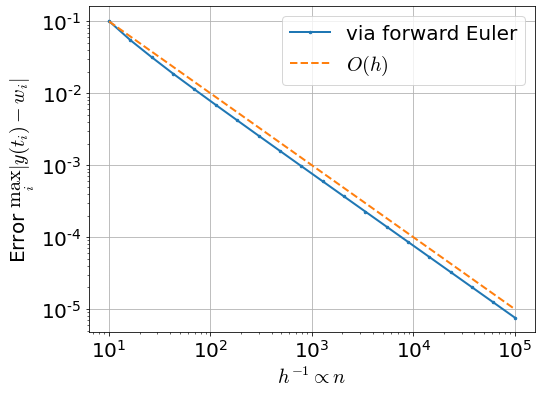

In [12]:
plt.loglog(1/hList, eList,".-",MarkerSize=5,label='via forward Euler');
plt.loglog(1/hList, hList,'--',label='$O(h)$');
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.xlabel('$h^{-1} \propto n$')
plt.legend();
plt.grid()

As we'll learn about in the Runge-Kutta section, there's a simple modification to Euler's method, called **improved Euler's method**, that requires just once extra call to $f(t,y)$ at each step, so it has twice the cost

In [14]:
def improved_Euler( f, y0, tspan, h=0.1, dense_output=False):
  """ Solve IVP y' = f(t,y) on a <= t <= b, y(a)=y0, via improved Euler with stepsize h
  This code has NOT been tested to work with systems.
  Returns tHist, wHist where wHist[i] approximates y( tHist[i] )
  """
  if len(tspan) is not 2:
    raise ValueError("tspan must be array of length 2")
  a, b = tspan[0], tspan[1]  
  # Initialize
  t    = a
  w    = y0
  # Update history
  tHist = [t]
  wHist = [w]
  dydtHist = []
  # Loop
  while t < b :
    tNext = min(t+h,b)  # don't go too far
    hh    = tNext - t
    dydt  = f(t,w)
    #w    += hh*dydt # this is Euler's method
    wHalf = w + hh/2*dydt
    w     += hh*f(t+hh/2,wHalf)
    t     = tNext
    # Update history
    tHist.append(t)
    wHist.append(w)
    dydtHist.append(dydt)

  dydtHist.append( f(t,w) )# lagged

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(tHist,wHist,dydtHist)
    return np.array(tHist), np.array(wHist), sol
  else:  
    return np.array(tHist), np.array(wHist)

Let's run both methods systematically for different values of $h$

In [15]:
hList = np.logspace(-1,-5,20)
eList = [] # error list
eList_improvedEuler = []
for h in hList:
  tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=h,dense_output=True)
  t  = np.linspace(tspan[0],tspan[1],1000)
  err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
  eList.append( err )

  # now run *improved* Euler's method
  tHist, wHist, y_interpolated = improved_Euler( f, y0, tspan, h=h,dense_output=True)
  t  = np.linspace(tspan[0],tspan[1],1000)
  err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
  eList_improvedEuler.append( err )  

Plotting the results, we see improved Euler's method is $O(h^2)$, and has much lower error than regular Euler's method.

But wait a minute, we have to do twice as much work per iteration? Is it worth it?

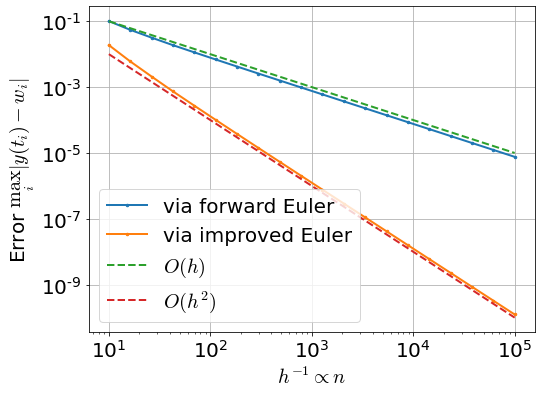

In [16]:
plt.loglog(1/hList, eList,".-",MarkerSize=5,label='via forward Euler');
plt.loglog(1/hList, eList_improvedEuler,".-",MarkerSize=5,label='via improved Euler');
plt.loglog(1/hList, hList,'--',label='$O(h)$');
plt.loglog(1/hList, hList**2,'--',label='$O(h^2)$');
plt.legend();
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.xlabel('$h^{-1} \propto n$');

... so to be fair, let's adjust the x-axis for improved Euler's method to take into account that we're doing twice as much work.

It's still **definitely** worth it

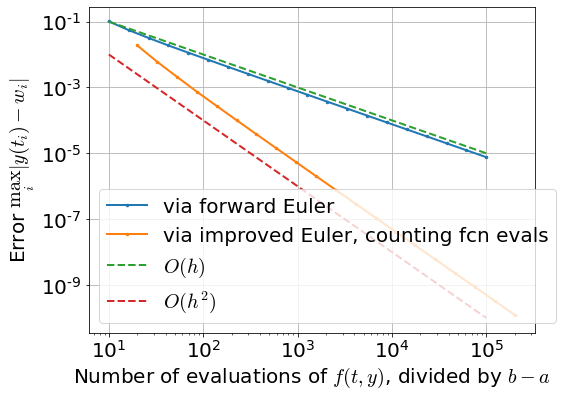

In [17]:
plt.loglog(1/hList, eList,".-",MarkerSize=5,label='via forward Euler');
plt.loglog(2/hList, np.array(eList_improvedEuler),".-",MarkerSize=5,label='via improved Euler, counting fcn evals');
plt.loglog(1/hList, hList,'--',label='$O(h)$');
plt.loglog(1/hList, hList**2,'--',label='$O(h^2)$');
plt.legend();
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.xlabel('Number of evaluations of $f(t,y)$, divided by $b-a$');

### Profiling (timing the code)

Since that took a little while to run, we might ask if we can make it faster, and if so, which part of the code to change.

To get data, we should **profile it**.  There are many tutorials online, such as this one from the [Python data science handbook](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html).  A full [IDE](https://en.wikipedia.org/wiki/Integrated_development_environment) like PyCharm or Spyder should have a good profiler.

Matlab has a great profiler; see [Profile Your Code to Improve Performance](https://www.mathworks.com/help/matlab/matlab_prog/profiling-for-improving-performance.html)

This first function, `prun`, comes with Python, and will show a breakdown of where time is spent

In [18]:
%prun tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=1e-5,dense_output=True)

We can also get more coarse grained timing. This repeats the code a few times to get some good numbers

In [19]:
%timeit tHist, wHist, y_interpolated = forward_Euler( f, y0, tspan, h=1e-5,dense_output=True)

1 loop, best of 3: 5.02 s per loop


In [20]:
%timeit tHist, wHist = forward_Euler( f, y0, tspan, h=1e-5,dense_output=False)

1 loop, best of 3: 4.69 s per loop


Seeing the results above, we wonder if we can write faster code that pre-allocates arrays. Let's try it:

In [21]:
from math import floor, ceil
import numba as nb    

#@nb.jit(nopython=True)
def forward_Euler_faster( f, y0, tspan, h=0.1):
  """ Solve IVP y' = f(t,y) on a <= t <= b, y(a)=y0, via improved Euler with stepsize h
  This code has NOT been tested to work with systems.
  Returns tHist, wHist where wHist[i] approximates y( tHist[i] )
  This is a more efficient implementation, though this style
  won't work well with a variable stepsize
  """
  if len(tspan) is not 2:
    raise ValueError("tspan must be array of length 2")
  a, b = tspan[0], tspan[1]  
  # Initialize
  t    = a
  w    = y0
  tHist, h = np.linspace(a,b,num=ceil((b-a)/h)+1,retstep=True)
  n    = len(tHist)
  wHist= np.zeros(n)
  wHist[0] = y0
  
  # for i in range(1,n):
  #   dydt  = f(tHist[i-1],w)
  #   w     += h*dydt
  #   wHist[i] = w

    # Slower:
    #dydt  = f(tHist[i-1],wHist[i-1])
    #wHist[i] = wHist[i-1] + h*dydt

  for i in range(1,n):
    dydt  = f(t,w)
    w     += h*dydt
    t     += h
    wHist[i] = w

  return tHist, wHist

and first check that we get (roughly) the same answer as before:

In [22]:
t,w   = forward_Euler_faster( f, y0, tspan, h=1e-3)
t2,w2 = forward_Euler( f, y0, tspan, h=1e-3)
print(f'Discrepancy in implementations is {np.linalg.norm( w-w2, ord=np.inf):.3e}')

Discrepancy in implementations is 1.006e-12


Now time it. We find that it's not really faster, and even a bit slower.  That's not uncommon -- we try to fix something but introduce something else slow.  Also, results may depend on the CPU and architecture, or version of the Python interpreter

In [23]:
%timeit tHist, wHist = forward_Euler_faster( f, y0, tspan, h=1e-5)

1 loop, best of 3: 4.96 s per loop
